In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def add_label_noise(labels, p=0.1):
    num_labels = int(len(labels))
    num_change = int(p * len(labels))
    
    idx = torch.randperm(num_labels)[:num_change]

    new_labels = torch.randint(0, 10, (num_change,))
    labels[idx] = new_labels
    return labels
print(add_label_noise(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0]), 0.8))

trainset.targets = add_label_noise(torch.tensor(trainset.targets), p=0.15).tolist()

tensor([6, 6, 9, 5, 5, 6, 2, 7, 2, 9])


In [5]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                                
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

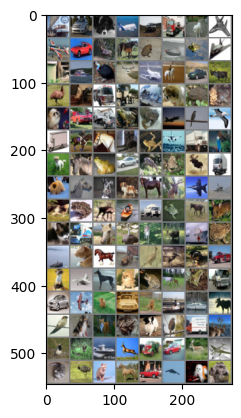

ship  car   dog   plane car   truck dog   plane plane car   deer  horse dog   ship  frog  plane cat   truck bird  deer  plane horse car   deer  cat   cat   cat   plane ship  dog   frog  frog  dog   horse truck frog  frog  cat   bird  bird  truck horse horse dog   frog  bird  truck bird  dog   dog   frog  car   deer  frog  car   truck dog   horse dog   dog   ship  deer  plane plane cat   frog  deer  ship  truck plane cat   deer  cat   truck horse bird  deer  horse cat   frog  ship  cat   horse dog   bird  deer  dog   cat   bird  plane dog   dog   frog  horse plane truck car   plane dog   car   cat   ship  cat   deer  car   dog   cat   frog  dog   bird  truck deer  bird  deer  ship  deer  truck car   cat   plane cat   bird  dog   horse car   plane dog   dog  


In [6]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from resnet import ResNet

In [8]:
def estimate_loss(net, split="train"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
    return loss / len(loader)

In [44]:
def run_experiment(k=64, epochs=10):
    net = ResNet(k).to(device)
    n_params = sum(p.numel() for p in net.parameters())
    print(f'Width: {k}')
    print(f'Number of parameters: {n_params}')

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

    test_lossi = []
    lossi = []

    test_loss = estimate_loss(net, "test")
    test_lossi.append(test_loss)

    train_loss = estimate_loss(net, "train")
    lossi.append(train_loss)

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] running loss: {running_loss / 100:.3f}, loss: {loss.item():.3f}')
                lossi.append(running_loss / 100)
                running_loss = 0.0
        
        test_loss = estimate_loss(net, "test")
        test_lossi.append(test_loss)
        print(f'[{epoch + 1}] test loss: {test_loss:.3f}')
    
    return net, lossi, test_lossi


In [45]:
# testing
net, lossi, test_lossi = run_experiment(16, 5)

Width: 16
Number of parameters: 701482
[1,   100] running loss: 1.998, loss: 1.833
[1,   200] running loss: 1.779, loss: 1.741
[1,   300] running loss: 1.713, loss: 1.855
[1] test loss: 1.397
[2,   100] running loss: 1.600, loss: 1.477
[2,   200] running loss: 1.582, loss: 1.643
[2,   300] running loss: 1.551, loss: 1.522
[2] test loss: 1.263
[3,   100] running loss: 1.494, loss: 1.579
[3,   200] running loss: 1.486, loss: 1.552
[3,   300] running loss: 1.455, loss: 1.513
[3] test loss: 1.167
[4,   100] running loss: 1.416, loss: 1.408
[4,   200] running loss: 1.403, loss: 1.330
[4,   300] running loss: 1.400, loss: 1.257
[4] test loss: 1.109
[5,   100] running loss: 1.348, loss: 1.321
[5,   200] running loss: 1.331, loss: 1.269
[5,   300] running loss: 1.350, loss: 1.314
[5] test loss: 1.063


16 6
tensor([0.0000, 0.3333, 0.6667, 1.0000, 1.3333, 1.6667, 2.0000, 2.3333, 2.6667,
        3.0000, 3.3333, 3.6667, 4.0000, 4.3333, 4.6667, 5.0000]) 16


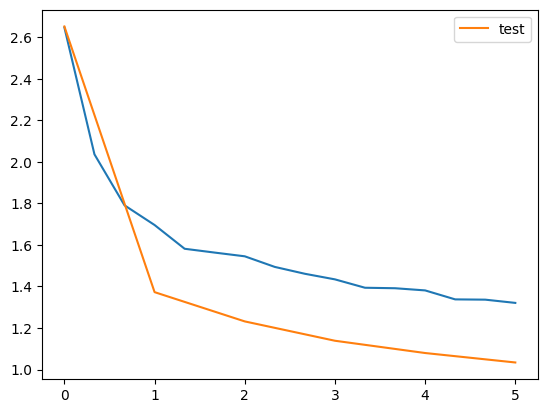

In [12]:
# plt.plot(lossi, torch.arange(len(lossi)) / len(test_lossi), label='train')
xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
print(len(lossi), len(test_lossi))
print(xs, len(xs))
# plt.plot(lossi, xs, label='train')
plt.plot(xs, lossi)
plt.plot(test_lossi, label='test')
plt.legend()
plt.show()

In [40]:
sizes = list(range(4, 32, 4))

losses = {}

for size in sizes:
    print(f'Running experiment with width {size}')
    net, lossi, test_lossi = run_experiment(size, 5)
    losses[size] = (lossi, test_lossi)

    print(f'Finished experiment with width {size}')
    print('\n\n\n\n\n')
    del net

Running experiment with width 4
Width: 4
Number of parameters: 44626
[1,   100] loss: 2.296
[1,   200] loss: 2.123
[1,   300] loss: 2.049
[1] test loss: 1.860
[2,   100] loss: 1.930
[2,   200] loss: 1.901
[2,   300] loss: 1.874
[2] test loss: 1.690
[3,   100] loss: 1.814
[3,   200] loss: 1.815
[3,   300] loss: 1.793
[3] test loss: 1.600
[4,   100] loss: 1.763
[4,   200] loss: 1.740
[4,   300] loss: 1.752
[4] test loss: 1.542
[5,   100] loss: 1.710
[5,   200] loss: 1.724
[5,   300] loss: 1.701
[5] test loss: 1.507
Finished experiment with width 4






Running experiment with width 8
Width: 8
Number of parameters: 176410
[1,   100] loss: 2.134
[1,   200] loss: 1.921
[1,   300] loss: 1.856
[1] test loss: 1.602
[2,   100] loss: 1.750
[2,   200] loss: 1.727
[2,   300] loss: 1.702
[2] test loss: 1.447
[3,   100] loss: 1.648
[3,   200] loss: 1.617
[3,   300] loss: 1.610
[3] test loss: 1.368
[4,   100] loss: 1.583
[4,   200] loss: 1.563
[4,   300] loss: 1.560
[4] test loss: 1.295
[5,   100] l

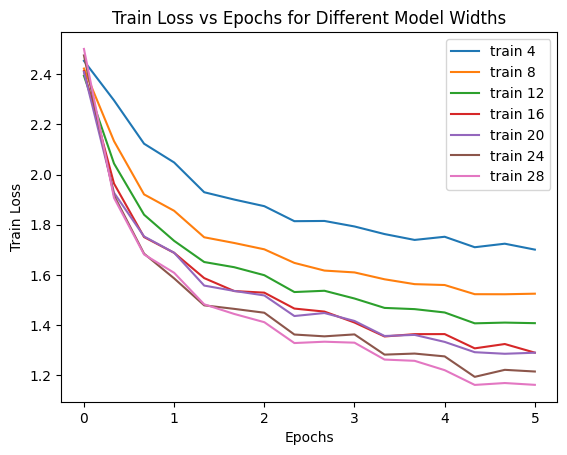

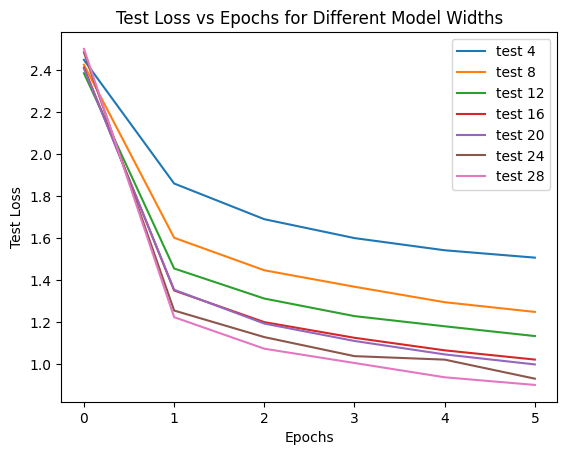

In [41]:
for size in sizes:
    lossi, test_lossi = losses[size]
    xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
    plt.plot(xs, lossi, label=f'train {size}')

plt.title('Train Loss vs Epochs for Different Model Widths')
plt.ylabel('Train Loss')
plt.xlabel('Epochs')

plt.legend()
plt.show()


for size in sizes:
    lossi, test_lossi = losses[size]
    plt.plot(test_lossi, label=f'test {size}')

plt.title('Test Loss vs Epochs for Different Model Widths')
plt.ylabel('Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

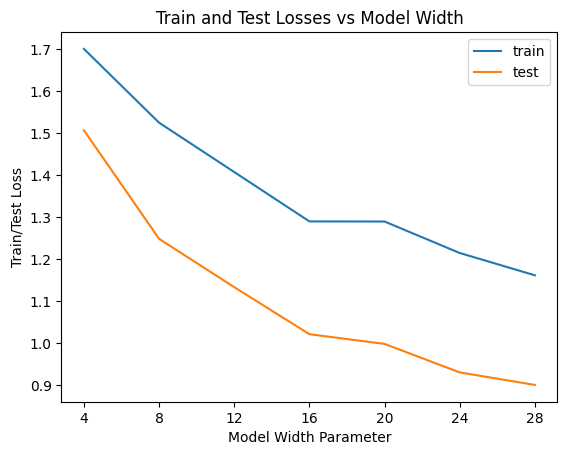

In [42]:
last_test_losses = [losses[size][1][-1] for size in sizes]
last_train_losses = [losses[size][0][-1] for size in sizes]

plt.title("Train and Test Losses vs Model Width")
plt.plot(sizes, last_train_losses, label='train')
plt.plot(sizes, last_test_losses, label='test')

plt.xticks(sizes)
plt.xlabel('Model Width Parameter')
plt.ylabel('Train/Test Loss')

plt.legend()
plt.show()